# Image Segmentation

* This code is **only** `tensorflow API` version for [TensorFlow tutorials/Image Segmentation](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb) which is made of `tf.keras`.
* You can see the detail description [tutorial link](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb) 

* I use below dataset instead of [carvana-image-masking-challenge dataset](https://www.kaggle.com/c/carvana-image-masking-challenge/rules) in TensorFlow Tutorials which is a kaggle competition dataset.
  * carvana-image-masking-challenge dataset: Too large dataset (14GB)
* [Gastrointestinal Image ANAlys Challenges (GIANA)](https://giana.grand-challenge.org) Dataset (345MB)
  * Train data: 300 images with RGB channels (bmp format)
  * Train lables: 300 images with 1 channels (bmp format)
  * Image size: 574 x 500

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
slim = tf.contrib.slim

tf.logging.set_verbosity(tf.logging.INFO)

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Get all the files 
Since this tutorial will be using a dataset from [Giana Dataset](https://giana.grand-challenge.org/Dates/).

In [2]:
# Unfortunately you cannot downlaod GIANA dataset from website
# So I upload zip file on my dropbox
# if you want to download from my dropbox uncomment below
#!wget https://goo.gl/mxikqa
#!mv mxikqa sd_train.zip
#!unzip sd_train.zip
#!mkdir ../../datasets
#!mv sd_train ../../datasets
#!rm sd_train.zip

In [3]:
dataset_dir = '../../datasets/sd_train'
img_dir = os.path.join(dataset_dir, "train")
label_dir = os.path.join(dataset_dir, "train_labels")

In [4]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [5]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=219)

In [6]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


### Here's what the paths look like

In [7]:
x_train_filenames[:10]

['../../datasets/sd_train/train/136.bmp',
 '../../datasets/sd_train/train/145.bmp',
 '../../datasets/sd_train/train/14.bmp',
 '../../datasets/sd_train/train/49.bmp',
 '../../datasets/sd_train/train/32.bmp',
 '../../datasets/sd_train/train/291.bmp',
 '../../datasets/sd_train/train/116.bmp',
 '../../datasets/sd_train/train/202.bmp',
 '../../datasets/sd_train/train/218.bmp',
 '../../datasets/sd_train/train/196.bmp']

In [8]:
y_train_filenames[:10]

['../../datasets/sd_train/train_labels/136.bmp',
 '../../datasets/sd_train/train_labels/145.bmp',
 '../../datasets/sd_train/train_labels/14.bmp',
 '../../datasets/sd_train/train_labels/49.bmp',
 '../../datasets/sd_train/train_labels/32.bmp',
 '../../datasets/sd_train/train_labels/291.bmp',
 '../../datasets/sd_train/train_labels/116.bmp',
 '../../datasets/sd_train/train_labels/202.bmp',
 '../../datasets/sd_train/train_labels/218.bmp',
 '../../datasets/sd_train/train_labels/196.bmp']

In [9]:
y_test_filenames[:10]

['../../datasets/sd_train/train_labels/239.bmp',
 '../../datasets/sd_train/train_labels/109.bmp',
 '../../datasets/sd_train/train_labels/173.bmp',
 '../../datasets/sd_train/train_labels/284.bmp',
 '../../datasets/sd_train/train_labels/174.bmp',
 '../../datasets/sd_train/train_labels/179.bmp',
 '../../datasets/sd_train/train_labels/178.bmp',
 '../../datasets/sd_train/train_labels/19.bmp',
 '../../datasets/sd_train/train_labels/166.bmp',
 '../../datasets/sd_train/train_labels/18.bmp']

# Visualize
Let's take a look at some of the examples of different images in our dataset. 

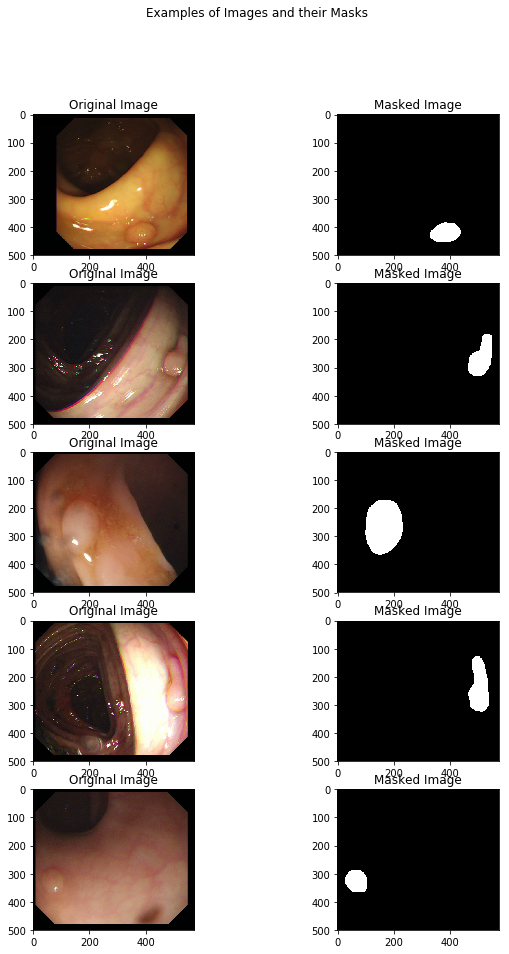

In [10]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(Image.open(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(example_labels)
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

# Set up

Let’s begin by setting up some parameters. We’ll standardize and resize all the shapes of the images. We’ll also set up some training parameters: 

In [11]:
# Set hyperparameters
image_size = 128
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 100
print_steps = 50
save_epochs = 50
train_dir = 'train/exp1'

# Build our input pipeline with `tf.data`
Since we begin with filenames, we will need to build a robust and scalable data pipeline that will play nicely with our model. If you are unfamiliar with **tf.data** you should check out my other tutorial introducing the concept! 

### Our input pipeline will consist of the following steps:
1. Read the bytes of the file in from the filename - for both the image and the label. Recall that our labels are actually images with each pixel annotated as car or background (1, 0). 
2. Decode the bytes into an image format
3. Apply image transformations: (optional, according to input parameters)
  * `resize` - Resize our images to a standard size (as determined by eda or computation/memory restrictions)
    * The reason why this is optional is that U-Net is a fully convolutional network (e.g. with no fully connected units) and is thus not dependent on the input size. However, if you choose to not resize the images, you must use a batch size of 1, since you cannot batch variable image size together
    * Alternatively, you could also bucket your images together and resize them per mini-batch to avoid resizing images as much, as resizing may affect your performance through interpolation, etc.
  * `hue_delta` - Adjusts the hue of an RGB image by a random factor. This is only applied to the actual image (not our label image). The `hue_delta` must be in the interval `[0, 0.5]` 
  * `horizontal_flip` - flip the image horizontally along the central axis with a 0.5 probability. This transformation must be applied to both the label and the actual image. 
  * `width_shift_range` and `height_shift_range` are ranges (as a fraction of total width or height) within which to randomly translate the image either horizontally or vertically. This transformation must be applied to both the label and the actual image. 
  * `rescale` - rescale the image by a certain factor, e.g. 1/ 255.
4. Shuffle the data, repeat the data (so we can iterate over it multiple times across epochs), batch the data, then prefetch a batch (for efficiency).

It is important to note that these transformations that occur in your data pipeline must be symbolic transformations. 

#### Why do we do these image transformations?
This is known as **data augmentation**. Data augmentation "increases" the amount of training data by augmenting them via a number of random transformations. During training time, our model would never see twice the exact same picture. This helps prevent [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting) and helps the model generalize better to unseen data.

## Processing each pathname

In [12]:
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair
  img_str = tf.read_file(fname)
  img = tf.image.decode_bmp(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  label_img = tf.image.decode_bmp(label_img_str, channels=1)
  
  resize = [image_size, image_size]
  img = tf.image.resize_images(img, resize)
  label_img = tf.image.resize_images(label_img, resize)
  
  scale = 1 / 255.
  img = tf.to_float(img) * scale
  label_img = tf.to_float(label_img) * scale
  
  return img, label_img

In [13]:
def get_baseline_dataset(filenames,
                         labels,
                         threads=5,
                         batch_size=batch_size,
                         max_epochs=max_epochs,
                         shuffle=True):
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x * 10)
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat(max_epochs).batch(batch_size)
  return dataset

## Set up train and test datasets
Note that we apply image augmentation to our training dataset but not our validation dataset.

In [14]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames)
test_ds = get_baseline_dataset(x_test_filenames,
                               y_test_filenames,
                               shuffle=False)

In [15]:
train_ds

<BatchDataset shapes: ((?, 128, 128, 3), (?, 128, 128, 1)), types: (tf.float32, tf.float32)>

### Plot some train data

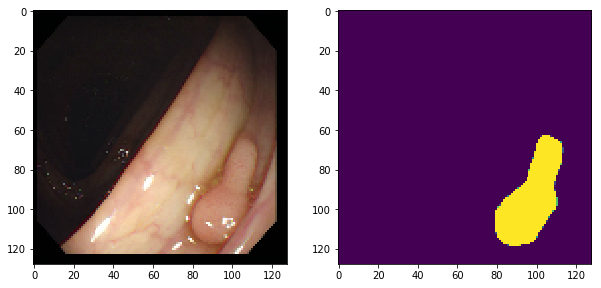

In [16]:
temp_ds = get_baseline_dataset(x_train_filenames,
                               y_train_filenames,
                               batch_size=1,
                               max_epochs=1,
                               shuffle=False)
# Let's examine some of these augmented images
temp_iter = temp_ds.make_one_shot_iterator()
next_element = temp_iter.get_next()
with tf.Session() as sess:
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = batch_of_imgs[0]

  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  plt.imshow(label[0, :, :, 0])
  plt.show()

# Build the model
We'll build the U-Net model. U-Net is especially good with segmentation tasks because it can localize well to provide high resolution segmentation masks. In addition, it works well with small datasets and is relatively robust against overfitting as the training data is in terms of the number of patches within an image, which is much larger than the number of training images itself. Unlike the original model, we will add batch normalization to each of our blocks. 

The Unet is built with an encoder portion and a decoder portion. The encoder portion is composed of a linear stack of [`Conv`](https://developers.google.com/machine-learning/glossary/#convolution), `BatchNorm`, and [`Relu`](https://developers.google.com/machine-learning/glossary/#ReLU) operations followed by a [`MaxPool`](https://developers.google.com/machine-learning/glossary/#pooling). Each `MaxPool` will reduce the spatial resolution of our feature map by a factor of 2. We keep track of the outputs of each block as we feed these high resolution feature maps with the decoder portion. The Decoder portion is comprised of UpSampling2D, Conv, BatchNorm, and Relus. Note that we concatenate the feature map of the same size on the decoder side. Finally, we add a final Conv operation that performs a convolution along the channels for each individual pixel (kernel size of (1, 1)) that outputs our final segmentation mask in grayscale. 

In [17]:
def conv_block(inputs, num_outputs, is_training, scope):
  batch_norm_params = {'decay': 0.9,
                       'epsilon': 0.001,
                       'is_training': is_training,
                       'scope': 'batch_norm'}
  with tf.variable_scope(scope) as scope:
    with slim.arg_scope([slim.conv2d],
                        num_outputs=num_outputs,
                        kernel_size=[3, 3],
                        normalizer_fn=slim.batch_norm,
                        normalizer_params=batch_norm_params):
      encoder = slim.conv2d(inputs, scope='conv1')
      encoder = slim.conv2d(encoder, scope='conv2')
      return encoder

def encoder_block(inputs, num_outputs, is_training, scope):
  with tf.variable_scope(scope) as scope:
    encoder = conv_block(inputs, num_outputs, is_training, scope)
    encoder_pool = slim.max_pool2d(encoder, kernel_size=[2, 2], scope='pool')
  
    return encoder_pool, encoder

def decoder_block(inputs, concat_tensor, num_outputs, is_training, scope):
  batch_norm_params = {'decay': 0.9,
                       'epsilon': 0.001,
                       'is_training': is_training,
                       'scope': 'batch_norm'}
  with tf.variable_scope(scope) as scope:
    decoder = slim.conv2d_transpose(inputs, num_outputs,
                                    kernel_size=[2, 2], stride=[2, 2],
                                    activation_fn=None, scope='convT')
    decoder = tf.concat([concat_tensor, decoder], axis=-1)
    decoder = slim.batch_norm(decoder, **batch_norm_params)
    decoder = tf.nn.relu(decoder)
    with slim.arg_scope([slim.conv2d],
                        num_outputs=num_outputs,
                        kernel_size=[3, 3],
                        stride=[1, 1],
                        normalizer_fn=slim.batch_norm,
                        normalizer_params=batch_norm_params):
      decoder = slim.conv2d(decoder, scope='conv1')
      decoder = slim.conv2d(decoder, scope='conv2')
      return decoder

In [18]:
class UNet(object):
  def __init__(self, train_ds, test_ds):
    self.train_ds = train_ds
    self.test_ds = test_ds
    
  def build_images(self):
    # tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
    self.handle = tf.placeholder(tf.string, shape=[])
    self.iterator = tf.data.Iterator.from_string_handle(self.handle,
                                                        self.train_ds.output_types,
                                                        self.train_ds.output_shapes)
    self.input_images, self.targets = self.iterator.get_next()
  
  def inference(self, inputs, is_training, reuse=False):
    with tf.variable_scope('', reuse=reuse) as scope:
      # inputs: [128, 128, 3]
      encoder0_pool, encoder0 = encoder_block(inputs, 32, is_training, 'encoder0')
      # encoder0_pool: [64, 64, 32], encoder0: [128, 128, 32]
      encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64, is_training, 'encoder1')
      # encoder1_pool: [32, 32, 64], encoder1: [64, 64, 64]
      encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128, is_training, 'encoder2')
      # encoder2_pool: [16, 16, 128], encoder2: [32, 32, 128]
      encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256, is_training, 'encoder3')
      # encoder3_pool: [8, 8, 256], encoder3: [16, 16, 256]
      center = conv_block(encoder3_pool, 512, is_training, 'center')
      # center: [8, 8, 512]
      decoder3 = decoder_block(center, encoder3, 256, is_training, 'decoder3')
      # decoder3 = [16, 16, 256]
      decoder2 = decoder_block(decoder3, encoder2, 128, is_training, 'decoder2')
      # decoder2 = [32, 32, 128]
      decoder1 = decoder_block(decoder2, encoder1, 64, is_training, 'decoder1')
      # decoder1 = [64, 64, 64]
      decoder0 = decoder_block(decoder1, encoder0, 32, is_training, 'decoder0')
      # decoder0 = [128, 128, 32]
      logits = slim.conv2d(decoder0, 1, [1, 1], activation_fn=None, scope='outputs')
      # logits = [128, 128, 1]

      return logits
  
  def dice_coeff(self, y_true, y_logits):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(tf.nn.sigmoid(y_logits), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score
  
  def dice_loss(self, y_true, y_logits):
    loss = 1 - self.dice_coeff(y_true, y_logits)
    return loss
  
  def bce_dice_loss(self, y_true, y_logits):
    loss = tf.losses.sigmoid_cross_entropy(y_true, y_logits) + self.dice_loss(y_true, y_logits)
    return loss
  
  def build(self):
    self.global_step = tf.train.get_or_create_global_step()
    
    self.build_images()
    self.logits = self.inference(self.input_images, is_training=True)
    self.logits_val = self.inference(self.input_images, is_training=False, reuse=True)
    self.predicted_images = tf.nn.sigmoid(self.logits_val)

    self.loss = self.bce_dice_loss(self.targets, self.logits)
    
    print("complete model build.")

### Create a model (UNet)

In [19]:
model = UNet(train_ds=train_ds, test_ds=test_ds)
model.build()

# show info for trainable variables
t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

complete model build.
---------
Variables: name (type shape) [size]
---------
encoder0/conv1/weights:0 (float32_ref 3x3x3x32) [864, bytes: 3456]
encoder0/conv1/batch_norm/beta:0 (float32_ref 32) [32, bytes: 128]
encoder0/conv2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
encoder0/conv2/batch_norm/beta:0 (float32_ref 32) [32, bytes: 128]
encoder1/conv1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
encoder1/conv1/batch_norm/beta:0 (float32_ref 64) [64, bytes: 256]
encoder1/conv2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
encoder1/conv2/batch_norm/beta:0 (float32_ref 64) [64, bytes: 256]
encoder2/conv1/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
encoder2/conv1/batch_norm/beta:0 (float32_ref 128) [128, bytes: 512]
encoder2/conv2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
encoder2/conv2/batch_norm/beta:0 (float32_ref 128) [128, bytes: 512]
encoder3/conv1/weights:0 (float32_ref 3x3x128x256) [294912, bytes: 1179648]
encoder3/con

(7761057, 31044228)

In [20]:
opt = tf.train.AdamOptimizer(learning_rate=2e-4)
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
  opt_op = opt.minimize(model.loss, global_step=model.global_step)

In [21]:
saver = tf.train.Saver(tf.global_variables(), max_to_keep=1000)

### Train a model

Epochs: 98.33 global_step: 2950 loss: 0.090 (248.52 examples/sec; 0.032 sec/batch)


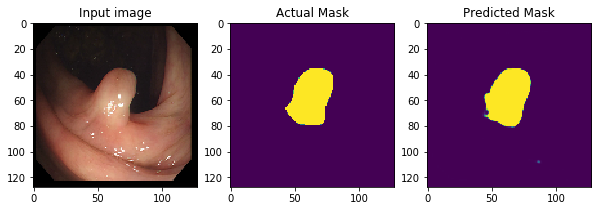

End of dataset
INFO:tensorflow:Saving model with global step 2999 (= 99 epochs) to disk.
INFO:tensorflow:complete training...
CPU times: user 2min 32s, sys: 56.8 s, total: 3min 29s
Wall time: 2min 6s


In [22]:
%%time
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())
tf.logging.info('Start Session.')

train_iterator = train_ds.make_one_shot_iterator()
train_handle = sess.run(train_iterator.string_handle())
test_iterator = test_ds.make_one_shot_iterator()
test_handle = sess.run(test_iterator.string_handle())

# save loss values for plot
loss_history = []
pre_epochs = 0
while True:
  try:
    start_time = time.time()
    _, global_step_, loss = sess.run([opt_op,
                                      model.global_step,
                                      model.loss],
                                     feed_dict={model.handle: train_handle})

    epochs = global_step_ * batch_size / float(num_train_examples)
    duration = time.time() - start_time

    if global_step_ % print_steps == 0:
      clear_output(wait=True)
      examples_per_sec = batch_size  / float(duration)
      print("Epochs: {:.2f} global_step: {} loss: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step_, loss, examples_per_sec, duration))

      loss_history.append([epochs, loss])

      # print sample image
      img, label, predicted_label = sess.run([model.input_images, model.targets, model.predicted_images],
                                             feed_dict={model.handle: test_handle})
      plt.figure(figsize=(10, 20))
      plt.subplot(1, 3, 1)
      plt.imshow(img[0,: , :, :])
      plt.title("Input image")
  
      plt.subplot(1, 3, 2)
      plt.imshow(label[0, :, :, 0])
      plt.title("Actual Mask")
      
      plt.subplot(1, 3, 3)
      plt.imshow(predicted_label[0, :, :, 0])
      plt.title("Predicted Mask")
      plt.show()

    # save model checkpoint periodically
    if int(epochs) % save_epochs == 0  and  pre_epochs != int(epochs):
      tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step_, int(epochs)))
      saver.save(sess, train_dir + 'model.ckpt', global_step=global_step_)
      pre_epochs = int(epochs)

  except tf.errors.OutOfRangeError:
    print("End of dataset")  # ==> "End of dataset"
    tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step_, int(epochs)))
    saver.save(sess, train_dir + 'model.ckpt', global_step=global_step_)
    break

tf.logging.info('complete training...')

### Plot the loss

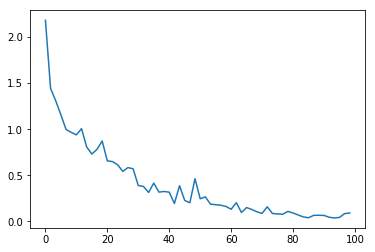

In [23]:
loss_history = np.asarray(loss_history)
plt.plot(loss_history[:,0], loss_history[:,1])
plt.show()

### Evaluate the test dataset and Plot

In [24]:
test_ds_eval = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    batch_size=num_test_examples,
                                    max_epochs=1,
                                    shuffle=False)

test_iterator_eval = test_ds_eval.make_one_shot_iterator()
test_handle_eval = sess.run(test_iterator_eval.string_handle())

In [25]:
mean_iou, mean_iou_op = tf.metrics.mean_iou(labels=tf.to_int32(tf.round(model.targets)),
                                            predictions=tf.to_int32(tf.round(model.predicted_images)),
                                            num_classes=2,
                                            name='mean_iou')
sess.run(tf.local_variables_initializer())

sess.run(mean_iou_op, feed_dict={model.handle: test_handle_eval})
print("mean iou:", sess.run(mean_iou))

mean iou: 0.87998605


#### Visualize testset

In [26]:
test_ds_visual = get_baseline_dataset(x_test_filenames, 
                                      y_test_filenames,
                                      batch_size=1,
                                      max_epochs=1,
                                      shuffle=False)

test_iterator_visual = test_ds_visual.make_one_shot_iterator()
test_handle_visual = sess.run(test_iterator_visual.string_handle())

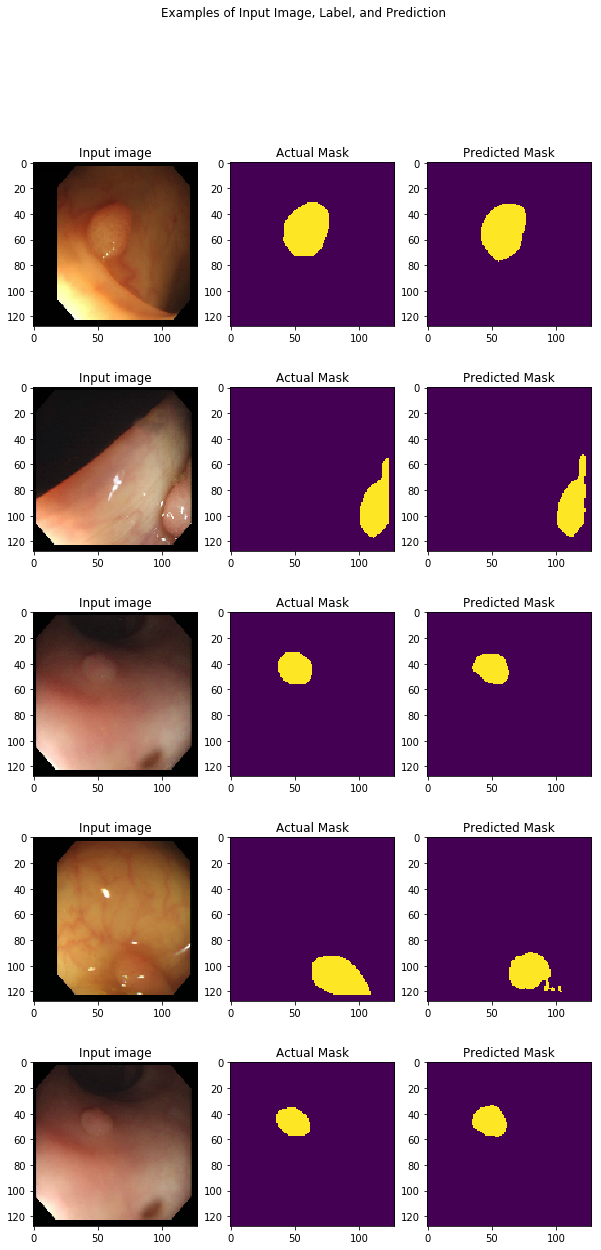

In [27]:
# Let's visualize some of the outputs 

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
  #img, label, predicted_label = sess.run([model.input_images, model.targets, model.predicted_images],
  img, label, predicted_label = sess.run([model.input_images,
                                          tf.to_int32(tf.round(model.targets)),
                                          tf.to_int32(tf.round(model.predicted_images))],
                                       feed_dict={model.handle: test_handle_visual})

  plt.subplot(5, 3, 3 * i + 1)
  plt.imshow(img[0,: , :, :])
  plt.title("Input image")

  plt.subplot(5, 3, 3 * i + 2)
  plt.imshow(label[0, :, :, 0])
  plt.title("Actual Mask")

  plt.subplot(5, 3, 3 * i + 3)
  plt.imshow(predicted_label[0, :, :, 0])
  plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()